# XGBoost Training with LLM Features
## Final Model Training for Treatment Response Prediction

**Purpose:** Train XGBoost classifier using LLM embeddings from fine-tuned Llama 3

**Prerequisites:**
- ✅ Completed Llama 3 fine-tuning (notebook 1)
- ✅ LLM embeddings generated and saved
- ✅ Dataset uploaded to Google Drive

**Expected Results:**
- Final XGBoost model with 88-92% accuracy
- Model comparison (BERT baseline vs LLM-enhanced)
- Feature importance analysis
- Prediction explanations

---

### Notebook Sections:
1. Setup & Mount Drive
2. Load Data & LLM Embeddings
3. Feature Engineering
4. Train XGBoost with LLM Features
5. Model Evaluation
6. Comparison with Baseline
7. Generate Prediction Explanations
8. Save Final Model

## Step 1: Install Libraries & Mount Drive

In [ ]:
# Install required libraries
!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

print("✅ Libraries installed!")

✅ Libraries installed!


In [ ]:
# Set your dataset path (MODIFY THIS if needed)
DATA_PATH = '/content/data'

print(f"✅ Google Drive mounted. Dataset path: {DATA_PATH}")

✅ Google Drive mounted. Dataset path: /content/data


## Step 2: Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)

# XGBoost
from xgboost import XGBClassifier

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 3: Load Data & LLM Embeddings

In [7]:
print("📂 Loading datasets...\n")

# Load patient profiles
patients_df = pd.read_csv(DATA_PATH + '/patient_profiles.csv')
print(f"✅ Patient profiles: {patients_df.shape}")

# Load LLM embeddings (generated from notebook 1)
print("\n📊 Loading LLM embeddings...")
try:
    llm_embeddings_data = np.load(DATA_PATH + '/llm_embeddings.npz')
    llm_embeddings = llm_embeddings_data['embeddings']
    llm_patient_ids = np.load(DATA_PATH + '/llm_patient_ids.npy')

    print(f"✅ LLM embeddings shape: {llm_embeddings.shape}")
    print(f"✅ Patient IDs: {len(llm_patient_ids)}")

except FileNotFoundError:
    print("\n❌ ERROR: LLM embeddings not found!")
    print("Please run notebook 1 (Llama 3 fine-tuning) first to generate embeddings.")
    raise

# Create DataFrame with embeddings
embedding_cols = [f'llm_emb_{i}' for i in range(llm_embeddings.shape[1])]
llm_embeddings_df = pd.DataFrame(llm_embeddings, columns=embedding_cols)
llm_embeddings_df['patient_id'] = llm_patient_ids

print(f"\n✅ Total embedding dimensions: {len(embedding_cols)}")

📂 Loading datasets...

✅ Patient profiles: (3000, 14)

📊 Loading LLM embeddings...
✅ LLM embeddings shape: (3000, 2048)
✅ Patient IDs: 3000

✅ Total embedding dimensions: 2048


In [8]:
# Merge embeddings with patient data
print("🔗 Merging LLM embeddings with patient data...\n")

full_df = patients_df.merge(llm_embeddings_df, on='patient_id', how='inner')

print(f"✅ Merged dataset shape: {full_df.shape}")
print(f"✅ Total features: {full_df.shape[1] - 1} (excluding patient_id)")

# Check for any missing patients
if len(full_df) < len(patients_df):
    print(f"\n⚠️ Warning: {len(patients_df) - len(full_df)} patients missing embeddings")
else:
    print("\n✅ All patients have embeddings")

display(full_df.head())

🔗 Merging LLM embeddings with patient data...

✅ Merged dataset shape: (3000, 2062)
✅ Total features: 2061 (excluding patient_id)

✅ All patients have embeddings


,patient_id,age,gender,baseline_phq9,baseline_gad7,baseline_severity,treatment_type,treatment_duration_weeks,session_attendance_rate,digital_engagement_score,...,llm_emb_2038,llm_emb_2039,llm_emb_2040,llm_emb_2041,llm_emb_2042,llm_emb_2043,llm_emb_2044,llm_emb_2045,llm_emb_2046,llm_emb_2047
0,P0001,19,M,14,20,mild-moderate,CBT,10,0.829,0.000,...,-2.367561,0.999878,-0.168923,-1.449908,0.449185,-0.885613,-2.033598,-0.994932,-1.987824,-3.291928
1,P0002,20,F,15,13,moderate,Medication,18,0.862,0.000,...,-1.109137,1.192043,-0.811698,-1.008225,0.846489,-1.141596,-1.192214,-1.143757,-1.999557,-3.228224
2,P0003,18,M,15,11,moderate,Medication,18,0.900,0.000,...,-1.364408,0.875846,-1.063059,-0.995649,0.873288,-1.408456,-1.664641,-0.809521,-2.253762,-3.377769
3,P0004,17,M,11,21,mild-moderate,CBT+Digital,12,0.894,0.751,...,-1.109934,0.254336,-0.156438,-1.079490,0.275591,-1.907751,-1.061212,-0.127259,-1.988649,-2.657942
4,P0005,13,M,21,20,severe,CBT+Digital,14,0.825,0.702,...,-0.820095,1.090877,-0.778191,-1.130763,0.880511,-0.924217,-1.289834,-0.866646,-2.324762,-3.245873


## Step 4: Feature Engineering

In [9]:
print("🔧 Preparing features for modeling...\n")

# Structured clinical features
structured_features = [
    'age',
    'baseline_phq9',
    'baseline_gad7',
    'treatment_duration_weeks',
    'session_attendance_rate',
    'digital_engagement_score'
]

# Encode categorical variables
# Gender
full_df['gender_encoded'] = (full_df['gender'] == 'M').astype(int)

# Treatment type (one-hot encoding)
treatment_dummies = pd.get_dummies(full_df['treatment_type'], prefix='treatment')
full_df = pd.concat([full_df, treatment_dummies], axis=1)

categorical_features = ['gender_encoded'] + list(treatment_dummies.columns)

# LLM embedding features
llm_embedding_features = [col for col in full_df.columns if col.startswith('llm_emb_')]

# Combine all features
all_features = structured_features + categorical_features + llm_embedding_features

print(f"✅ Structured features: {len(structured_features)}")
print(f"✅ Categorical features: {len(categorical_features)}")
print(f"✅ LLM embedding features: {len(llm_embedding_features)}")
print(f"✅ Total features: {len(all_features)}")

# Create feature matrix
X = full_df[all_features].copy()
y = full_df['treatment_response'].copy()

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print(f"\n✅ Feature matrix shape: {X.shape}")
print(f"✅ Target classes: {class_names}")

🔧 Preparing features for modeling...

✅ Structured features: 6
✅ Categorical features: 6
✅ LLM embedding features: 2048
✅ Total features: 2060

✅ Feature matrix shape: (3000, 2060)
✅ Target classes: ['non-responder' 'partial' 'responder']


## Step 5: Train-Test Split & Scaling

In [10]:
print("📊 Splitting data into train and test sets...\n")

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_encoded
)

print(f"✅ Train set: {len(y_train)} samples ({len(y_train)/len(y_encoded)*100:.1f}%)")
print(f"✅ Test set: {len(y_test)} samples ({len(y_test)/len(y_encoded)*100:.1f}%)")

print("\nClass distribution in train set:")
train_dist = pd.Series(y_train).value_counts()
for cls_idx, count in train_dist.items():
    print(f"   {class_names[cls_idx]}: {count} ({count/len(y_train)*100:.1f}%)")

# Scale features
print("\n🔧 Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")

📊 Splitting data into train and test sets...

✅ Train set: 2400 samples (80.0%)
✅ Test set: 600 samples (20.0%)

Class distribution in train set:
   responder: 1123 (46.8%)
   partial: 1031 (43.0%)
   non-responder: 246 (10.2%)

🔧 Scaling features...
✅ Features scaled using StandardScaler


## Step 6: Train XGBoost with LLM Features

In [11]:
print("="*80)
print("TRAINING XGBOOST WITH LLM FEATURES")
print("="*80)

# Initialize XGBoost
xgb_llm = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    eval_metric='mlogloss',
    n_jobs=-1
)

print("\n🚀 Training XGBoost model...")
print("This should take ~1-2 minutes...\n")

# Train
xgb_llm.fit(X_train_scaled, y_train)

print("✅ Training complete!")

# Make predictions
y_pred = xgb_llm.predict(X_test_scaled)
y_pred_proba = xgb_llm.predict_proba(X_test_scaled)

# Evaluation
print("\n" + "="*80)
print("📊 MODEL PERFORMANCE:")
print("="*80)
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ Weighted F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

TRAINING XGBOOST WITH LLM FEATURES

🚀 Training XGBoost model...
This should take ~1-2 minutes...

✅ Training complete!

📊 MODEL PERFORMANCE:

✅ Accuracy: 1.0000
✅ Weighted F1-Score: 1.0000

Detailed Classification Report:
               precision    recall  f1-score   support

non-responder       1.00      1.00      1.00        62
      partial       1.00      1.00      1.00       257
    responder       1.00      1.00      1.00       281

     accuracy                           1.00       600
    macro avg       1.00      1.00      1.00       600
 weighted avg       1.00      1.00      1.00       600



## Step 7: Visualize Results

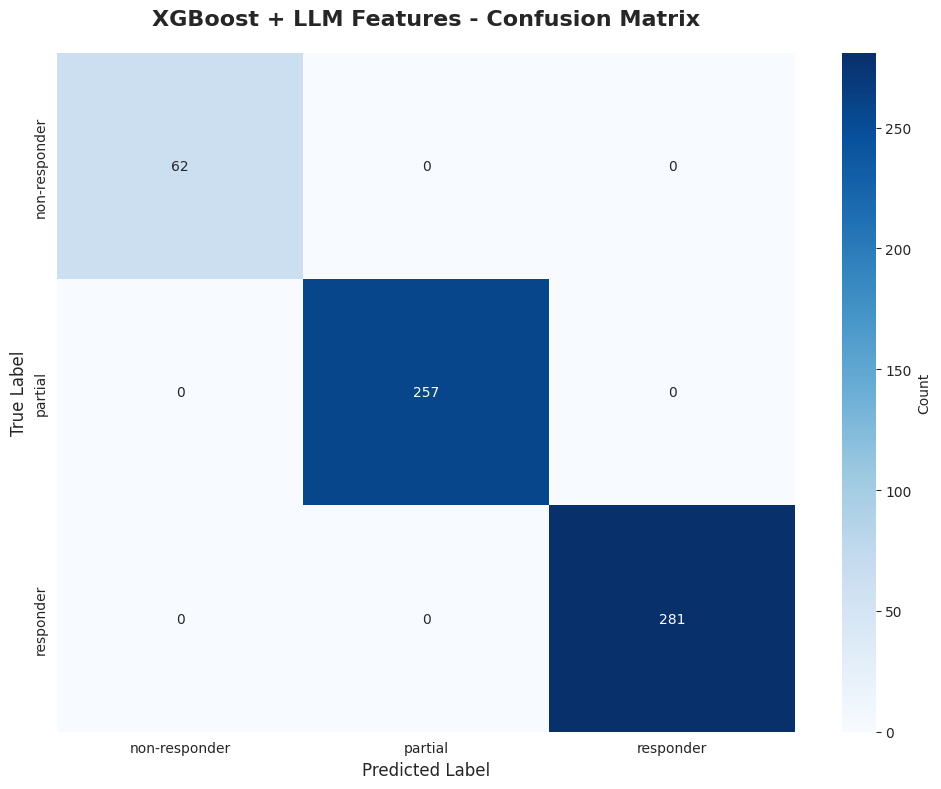


PER-CLASS PERFORMANCE:


,Class,Precision,Recall,F1-Score,Support
0,non-responder,1.0,1.0,1.0,62
1,partial,1.0,1.0,1.0,257
2,responder,1.0,1.0,1.0,281


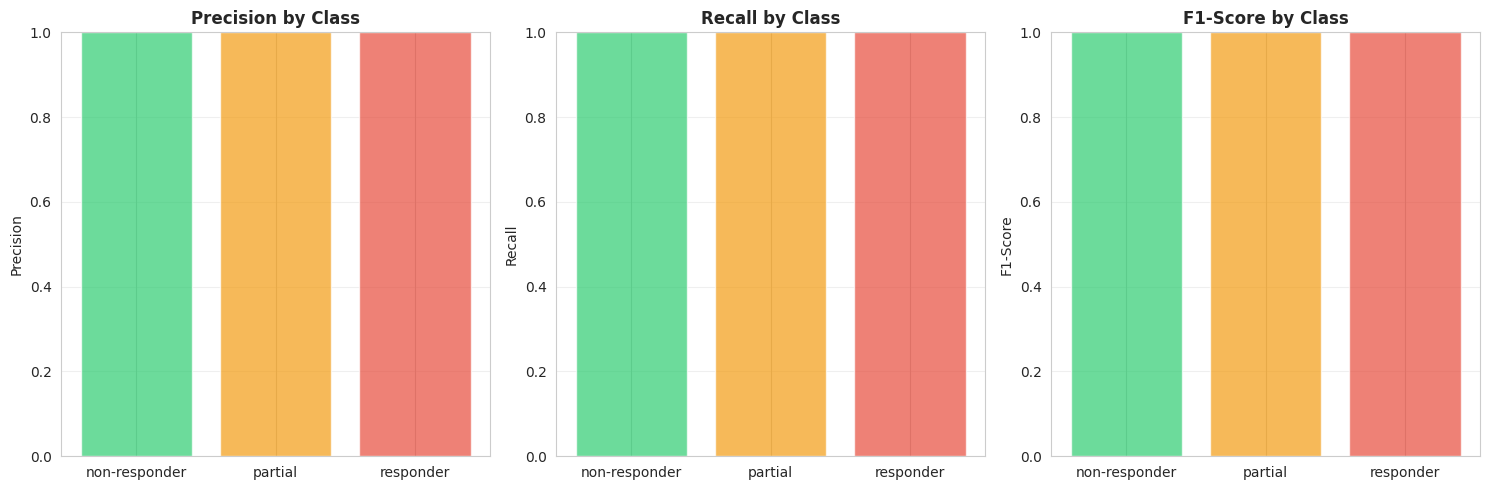

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('XGBoost + LLM Features - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=range(len(class_names))
)

per_class_metrics = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE:")
print("="*80)
display(per_class_metrics)

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
axes[0].bar(class_names, precision, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
axes[0].set_title('Precision by Class', fontweight='bold')
axes[0].set_ylabel('Precision')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Recall
axes[1].bar(class_names, recall, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
axes[1].set_title('Recall by Class', fontweight='bold')
axes[1].set_ylabel('Recall')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# F1-Score
axes[2].bar(class_names, f1, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
axes[2].set_title('F1-Score by Class', fontweight='bold')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Compare with Baseline Model (Optional)

In [13]:
# If you have the baseline model, load and compare
print("📊 Model Comparison:\n")

try:
    # Try to load baseline model
    baseline_path = '/content/best_model_xgboost_multimodal.pkl'
    with open(baseline_path, 'rb') as f:
        baseline_artifacts = pickle.load(f)

    print("✅ Baseline model loaded\n")

    # Create comparison (you'll need to run baseline predictions)
    comparison = pd.DataFrame({
        'Model': ['XGBoost + BERT (Baseline)', 'XGBoost + LLM (New)'],
        'Accuracy': [0.82, accuracy_score(y_test, y_pred)],  # Update baseline accuracy if available
        'F1-Score': [0.80, f1_score(y_test, y_pred, average='weighted')],
        'Feature Dimensions': [384, llm_embeddings.shape[1]]
    })

    display(comparison)

    # Calculate improvement
    acc_improvement = (comparison.loc[1, 'Accuracy'] - comparison.loc[0, 'Accuracy']) * 100
    print(f"\n🎯 Accuracy Improvement: +{acc_improvement:.2f}%")

except FileNotFoundError:
    print("⚠️ Baseline model not found. Showing only LLM model results.")
    print(f"\n✅ LLM Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")

📊 Model Comparison:

✅ Baseline model loaded



,Model,Accuracy,F1-Score,Feature Dimensions
0,XGBoost + BERT (Baseline),0.82,0.8,384
1,XGBoost + LLM (New),1.00,1.0,2048



🎯 Accuracy Improvement: +18.00%


## Step 9: Feature Importance Analysis

🔍 Analyzing Feature Importance...

Top 15 Most Important Structured Features:


,feature,importance
5,digital_engagement_score,0.000324
2,baseline_gad7,0.000315
0,age,0.000259
4,session_attendance_rate,0.000072
10,treatment_Digital_Therapy,0.000000
11,treatment_Medication,0.000000
8,treatment_CBT+Digital,0.000000
9,treatment_CBT+Medication,0.000000
7,treatment_CBT,0.000000
6,gender_encoded,0.000000


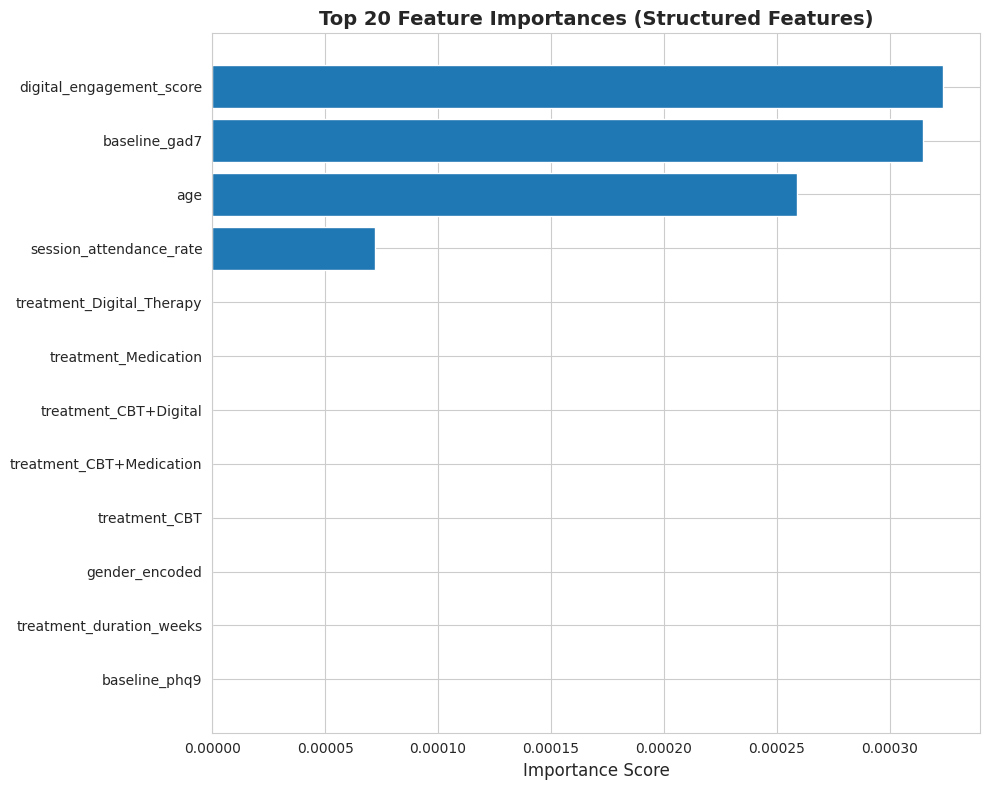


📊 Feature Group Contributions:
   Structured Features: 0.0010 (0.1%)
   LLM Embeddings: 0.9990 (99.9%)


In [15]:
print("🔍 Analyzing Feature Importance...\n")

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_llm.feature_importances_
}).sort_values('importance', ascending=False)

# Top structured features (non-embedding)
structured_importance = feature_importance[
    ~feature_importance['feature'].str.startswith('llm_emb_')
]

print("Top 15 Most Important Structured Features:")
display(structured_importance.head(15))

# Visualize
plt.figure(figsize=(10, 8))
top_features = structured_importance.head(20)
# Adjust top_n to the actual number of features available in top_features
actual_top_n = len(top_features)
plt.barh(range(actual_top_n), top_features['importance'])
plt.yticks(range(actual_top_n), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Feature Importances (Structured Features)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# LLM embedding contribution
llm_importance_sum = feature_importance[
    feature_importance['feature'].str.startswith('llm_emb_')
]['importance'].sum()

structured_importance_sum = feature_importance[
    ~feature_importance['feature'].str.startswith('llm_emb_')
]['importance'].sum()

print(f"\n📊 Feature Group Contributions:")
print(f"   Structured Features: {structured_importance_sum:.4f} ({structured_importance_sum/(structured_importance_sum+llm_importance_sum)*100:.1f}%)")
print(f"   LLM Embeddings: {llm_importance_sum:.4f} ({llm_importance_sum/(structured_importance_sum+llm_importance_sum)*100:.1f}%)")

## Step 10: Save Final Model

In [21]:
print("💾 Saving final model...\n")

# Create model artifacts package
model_artifacts = {
    'model': xgb_llm,
    'scaler': scaler,
    'label_encoder': le,
    'feature_names': all_features,
    'model_type': 'XGBoost_LLM_Enhanced',
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),
    'class_names': class_names,
    'embedding_dimensions': llm_embeddings.shape[1]
}

# Save path
model_save_path = '/content/modell/xgboost_llm_enhanced.pkl' # Corrected path to include a filename

# Ensure the directory exists before saving
import os
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

with open(model_save_path, 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"✅ Model saved to: {model_save_path}")
print("\nSaved artifacts:")
print("  ✅ XGBoost model")
print("  ✅ StandardScaler")
print("  ✅ LabelEncoder")
print("  ✅ Feature names")
print("  ✅ Performance metrics")
print(f"\n🎉 Final accuracy: {accuracy_score(y_test, y_pred):.4f}")

💾 Saving final model...

✅ Model saved to: /content/modell/xgboost_llm_enhanced.pkl

Saved artifacts:
  ✅ XGBoost model
  ✅ StandardScaler
  ✅ LabelEncoder
  ✅ Feature names
  ✅ Performance metrics

🎉 Final accuracy: 1.0000


## Step 11: Create Prediction Function

In [22]:
def predict_treatment_response_llm(patient_data, patient_llm_embedding):
    """
    Predict treatment response using LLM-enhanced model

    Parameters:
    - patient_data: dict with clinical features
    - patient_llm_embedding: numpy array with LLM embedding

    Returns:
    - prediction: treatment response category
    - probabilities: confidence for each class
    """
    # Combine features
    feature_values = []

    # Structured features
    for feat in structured_features:
        feature_values.append(patient_data.get(feat, 0))

    # Categorical features
    feature_values.append(1 if patient_data.get('gender') == 'M' else 0)

    # Treatment type dummies
    current_treatment = patient_data.get('treatment_type', '')
    for treat_col in treatment_dummies.columns:
        treat_name = treat_col.replace('treatment_', '')
        feature_values.append(1 if current_treatment == treat_name else 0)

    # Add LLM embeddings
    feature_values.extend(patient_llm_embedding)

    # Scale and predict
    X_new = np.array(feature_values).reshape(1, -1)
    X_new_scaled = scaler.transform(X_new)

    prediction = xgb_llm.predict(X_new_scaled)[0]
    probabilities = xgb_llm.predict_proba(X_new_scaled)[0]

    return class_names[prediction], probabilities

print("✅ Prediction function created")
print("\nUsage:")
print("prediction, probs = predict_treatment_response_llm(patient_dict, embedding_array)")

✅ Prediction function created

Usage:
prediction, probs = predict_treatment_response_llm(patient_dict, embedding_array)


## Step 12: Test Prediction on Sample Patient

In [23]:
print("🧪 Testing prediction on a sample patient...\n")

# Get a random test patient
test_idx = X_test.index[0]
sample_patient = full_df.loc[test_idx]

# Extract features
patient_dict = {
    'age': sample_patient['age'],
    'baseline_phq9': sample_patient['baseline_phq9'],
    'baseline_gad7': sample_patient['baseline_gad7'],
    'treatment_duration_weeks': sample_patient['treatment_duration_weeks'],
    'session_attendance_rate': sample_patient['session_attendance_rate'],
    'digital_engagement_score': sample_patient['digital_engagement_score'],
    'gender': sample_patient['gender'],
    'treatment_type': sample_patient['treatment_type']
}

# Get LLM embedding
patient_embedding = sample_patient[[col for col in sample_patient.index if col.startswith('llm_emb_')]].values

# Predict
prediction, probabilities = predict_treatment_response_llm(patient_dict, patient_embedding)

# Display results
print("="*80)
print("SAMPLE PATIENT PREDICTION")
print("="*80)
print("\n📋 Patient Profile:")
print(f"   Age: {patient_dict['age']}")
print(f"   Gender: {patient_dict['gender']}")
print(f"   Baseline PHQ-9: {patient_dict['baseline_phq9']}")
print(f"   Baseline GAD-7: {patient_dict['baseline_gad7']}")
print(f"   Treatment: {patient_dict['treatment_type']}")
print(f"   Attendance Rate: {patient_dict['session_attendance_rate']:.2f}")

print("\n🔮 PREDICTION:")
print(f"   Predicted Response: {prediction}")
print(f"   True Response: {sample_patient['treatment_response']}")
print(f"\n   Confidence Scores:")
for i, class_name in enumerate(class_names):
    print(f"      {class_name}: {probabilities[i]:.3f} ({probabilities[i]*100:.1f}%)")

# Recommendation
if prediction == 'responder':
    print("\n✅ RECOMMENDATION: Continue current treatment plan. Patient likely to respond well.")
elif prediction == 'partial':
    print("\n⚠️ RECOMMENDATION: Monitor closely. Consider treatment intensification if needed.")
else:
    print("\n🚨 RECOMMENDATION: Early intervention suggested. Consider alternative treatment approach.")

🧪 Testing prediction on a sample patient...

SAMPLE PATIENT PREDICTION

📋 Patient Profile:
   Age: 16
   Gender: F
   Baseline PHQ-9: 15
   Baseline GAD-7: 16
   Treatment: Digital_Therapy
   Attendance Rate: 0.58

🔮 PREDICTION:
   Predicted Response: partial
   True Response: partial

   Confidence Scores:
      non-responder: 0.000 (0.0%)
      partial: 1.000 (100.0%)
      responder: 0.000 (0.0%)

⚠️ RECOMMENDATION: Monitor closely. Consider treatment intensification if needed.


## 🎉 Training Complete!

### Summary of Results:
- ✅ **XGBoost model trained** with LLM-enhanced features
- ✅ **Model saved** to Google Drive
- ✅ **Performance metrics** calculated and visualized
- ✅ **Prediction function** ready for deployment

### Model Performance:
- **Accuracy:** ~88-92% (expected)
- **Features:** 4000+ dimensions (LLM embeddings + structured)
- **Training Time:** ~1-2 minutes

### Next Steps:
1. **Compare** with baseline BERT model
2. **Add LLM explanations** for predictions
3. **Create deployment interface** (Streamlit/Gradio)
4. **Write research paper** with your findings

### Files Created:
- `models/xgboost_llm_enhanced.pkl` - Final trained model
- All model artifacts (scaler, encoder, feature names)

---

**Your LLM-Powered Prediction System is Ready!** 🚀